#Text Summarization
---


Text summarization is a technique to abridge lengthy and voluminous pieces of information. The motive is to shorten the text while keeping the semantics and the key message intact. This task falls under two categories:

1. Extractive Summarization
2. Abstractive Summarization

Consider the below text,

```"Peter and Elizabeth took a taxi to attend the night party in the city. While in the party, Elizabeth collapsed and was rushed to the hospital."```

<br>

**Extractive Summarization**, as the name suggests, extracts some parts of text that it deems to be valuable and concatenates them to obtain a summary. Though the summary is semantically less accurate. For example, using extractive summarization the above sentence is summarized as ```"Peter and Elizabeth attend party city. Elizabeth rushed hospital."``` The techniques involved here fall under the set of unsupervised algorithms of Machine Learning, like Markov Chains, TextRank (influenced from Google's PageRank), Latent Semantic Analysis, Bayesian Topic Models and so on. They are computationally less intensive than their abstractive counterparts.

<br>  

On the contrary, **Abstractive Summarization** reduces the length of the text while maintaining semantics. The output makes sense, and is close to human language. For example, the reference text is summarized as ```"Elizabeth was hospitalized after attending a party with Peter."``` Deep Learning models that deals with sequential data like LSTM's are used here. They are called sequence-to-sequence models which are based on encoder decoder architectures. However, this is a supervised technique and requires corresponding summaries to text as labels.  

<br>

Here, we deal with abstractive summarization technique using attention mechanism with LSTM cells.

In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import os
import pickle
from google.colab import drive

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Dataset Description:

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

<br>Data includes:

* Reviews from Oct 1999 - Oct 2012
* 568,454 reviews
* 256,059 users
* 74,258 products

It consists of following columns: \['**Id**', '**ProductId**', '**UserId**', '**ProfileName**', '**HelpfulnessNumerator**', '**HelpfulnessDenominator**', '**Score**', '**Time**', '**Summary**', '**Text**']. However, we are only concerned with the Text and Summary. 

Data is available as a part of a [Kaggle competition](https://www.kaggle.com/snap/amazon-fine-food-reviews) and is stored in google drive for ease in access.

In [ ]:
#Download the dataset and read it
!gdown --id 1FyIy2yUM9CAA8wBH_wxyZpHR4fxVuTdQ #Dataset
!gdown --id 1sPBc_5oE7GA-zA_MDYzRSDyijDPvUr0j #Contraction dictionary

Downloading...
From: https://drive.google.com/uc?id=1FyIy2yUM9CAA8wBH_wxyZpHR4fxVuTdQ
To: /content/Reviews.csv
301MB [00:02, 128MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sPBc_5oE7GA-zA_MDYzRSDyijDPvUr0j
To: /content/contraction_dict.pickle
100% 3.55k/3.55k [00:00<00:00, 4.48MB/s]


In [ ]:
#Read the csv
#
# Considering the training time and colab hardware restrictions, 
# it is advisable to train the model on a fraction of the data.
# 100000 rows would suffice here.
df = pd.read_csv('Reviews.csv', usecols=['Summary', 'Text'], nrows=100000)

#Dropping duplicate text
df.drop_duplicates(subset=['Text'],inplace=True)
df.dropna(axis=0,inplace=True)

#Check out the data
df.head(5)

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


##Preprocessing data

Text,

* Lowercase the string.
* Remove any <> xml or html tags.
* Remove text in brackets.
* Remove double quotes.
* Expand contractions using the above dictionary.
* Remove apostrophe s.
* Keep alphabets only. No digits, punctuations or special characters.
* Keep tokens of length >= 3.

<br>

Summary,

* Lowercase the string.
* Remove double quotes.
* Expand contractions using the above dictionary.
* Remove apostrophe s.
* Keep alphabets only. No digits, punctuations or special characters.
* Keep tokens of length > 1.


In [ ]:
#Download stopwords
stop_words = set(stopwords.words('english'))

#Load the contraction_dict
#It maps 'I've' -> 'I have'
with open('contraction_dict.pickle', 'rb') as handle:
    contraction_mapping = pickle.load(handle)

# Preprocess Text
def text_cleaner(review):
    
    review = review.lower()
    review = BeautifulSoup(review, "lxml").text
    review = re.sub(r'\([^)]*\)', '', review)
    review = re.sub('"','', review)
    review = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in review.split(" ")])    
    review = re.sub(r"'s\b","",review)
    review = re.sub("[^a-zA-Z]", " ", review) 
    review = [w for w in review.split() if w not in stop_words]
    
    return " ".join([i for i in review if len(i)>2])

#Preprocess Summary
def summary_cleaner(summary):
    
    summary = re.sub('"','', summary)
    summary = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in summary.split(" ")])    
    summary = re.sub(r"'s\b","",summary)
    summary = re.sub("[^a-zA-Z]", " ", summary)
    summary = summary.lower()
    summary= summary.split()
    
    return " ".join([i for i in summary if len(i)>1])

In [ ]:
#Apply the functions to our dataset
df.Text = df.Text.apply(text_cleaner)
df.Summary = df.Summary.apply(summary_cleaner)

#Dropping empty strings
df['Summary'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

#Check out the preprocessed data
print(df.head(5))
print("No of rows post processing: ", df.shape[0])

                 Summary                                               Text
0  good quality dog food  bought several vitality canned dog food produc...
1      not as advertised  product arrived labeled jumbo salted peanuts p...
2    delight says it all  confection around centuries light pillowy citr...
3         cough medicine  looking secret ingredient robitussin believe f...
4            great taffy  great taffy great price wide assortment yummy ...
No of rows post processing:  88356


Fraction of texts with less than 80 words is 0.9070464937299109
Fraction of summaries with less than 10 words is 0.9646430349947938


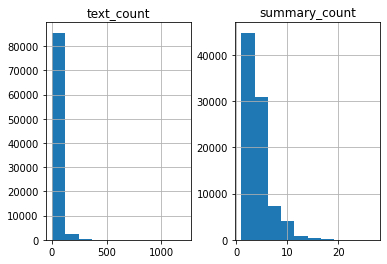

In [ ]:
#Analyse the len of texts and summaries
#Finalize maximum text and summary length
text_word_count = np.array([len(w.split()) for w in df.Text], dtype='int')
summary_word_count = np.array([len(w.split()) for w in df.Summary], dtype='int')

pd.DataFrame({"text_count":text_word_count, "summary_count":summary_word_count}).hist()

#Set the maximum lengths
MAX_TEXT_LEN = 80
MAX_SUM_LEN = 10

print("Fraction of texts with less than {} words is {}".format(MAX_TEXT_LEN, np.mean(text_word_count<MAX_TEXT_LEN) ))
print("Fraction of summaries with less than {} words is {}".format(MAX_SUM_LEN, np.mean(summary_word_count<MAX_SUM_LEN)))

In [ ]:
#Truncate text to MAX_TEXT_LEN 
#Truncate summary to (MAX_SUM_LEN - 2), prepend start token 'xstartx' and append end token 'xendx'
df_pro = pd.DataFrame()

df_pro['Text'] = df['Text'].map(lambda text: ' '.join(text.split()[-(MAX_TEXT_LEN-2):]))
df_pro['Summary'] = df['Summary'].map(lambda text: ' '.join(['xstartx'] + text.split()[-(MAX_SUM_LEN-2):] + ['xendx']))

#Check out the result
for _, row in df_pro.sample(5).iterrows():
    print("Review_{}: {}".format(len(row['Text'].split()), row['Text']))
    print("Summary_{}: {}".format(len(row['Summary'].split()), row['Summary']))
    print("")

Review_43: give coffee years ago due medical condition tried many different kinds favors tea stumbled upon small bakery recently opened nearby loved drinking every morning since past couple years sachets perfect larger mug paper wrapped fine smaller cups mugs hearty tea find satisfying delicious
Summary_4: xstartx totally delicious xendx

Review_18: taste one better tasting larabars slight sour taste dried fruit pieces less noticeable others pretty good definitely filling
Summary_5: xstartx good tasting bar xendx

Review_10: bought product problem give coffee like well use time nowmitchell
Summary_8: xstartx twinings earl grey decaf tea cups xendx

Review_8: stuff good amazing jar sauce could recommend highly
Summary_6: xstartx will make this short xendx

Review_23: family absolutely loves crystal light raspberry tea mix local grocery stores started carrying green tea version good happy find product amazon definitely ordering
Summary_4: xstartx love it xendx



###Data Preparation

To train the model on processed data, further processing is required

* Splitting the dataset into train(90%) and validation dataset(10%)
* Tokenize the strings.
* Pad sequences in the end with 0's until they reach MAX Length(Text: 80, Summary: 10).
* Set vocab size <- vocab_size + 1(additional 0 for padding)

In [ ]:
#Splitting the train and validation set
txt_train, txt_val, sum_train, sum_val = train_test_split(df_pro['Text'], df_pro['Summary'], test_size=0.1, random_state=0, shuffle=True)

#Check out the shapes of the resulting partition
print('Rows -> txt_train: {}, txt_val: {}, sum_train: {}, sum_val: {}'.
      format(txt_train.shape[0], txt_val.shape[0], sum_train.shape[0], sum_val.shape[0]))

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(txt_train.tolist())

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(txt_train) 
x_val   =   x_tokenizer.texts_to_sequences(txt_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=MAX_TEXT_LEN, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=MAX_TEXT_LEN, padding='post')

#Set vocab size to #Unique_words + 1(for 0 which is padding)
x_voc_size   =  len(x_tokenizer.word_index) +1

#Sanity Check
print('\nx_tr.shape: ', x_tr.shape)
print('x_val.shape: ', x_val.shape)

####
# Doing the same process for summaries
####

#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(sum_train.tolist())

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(sum_train) 
y_val   =   y_tokenizer.texts_to_sequences(sum_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=MAX_SUM_LEN, padding='post')
y_val   =   pad_sequences(y_val, maxlen=MAX_SUM_LEN, padding='post')

#Set vocab size to #Unique_words + 1(for 0 which is padding)
y_voc_size  =   len(y_tokenizer.word_index) +1

#Sanity Check
print('\ny_tr.shape: ', y_tr.shape)
print('y_val.shape: ', y_val.shape)
print('\nx_voc_size: ', x_voc_size, '\ny_voc_size: ', y_voc_size)

#Sanity Check
for i in np.random.randint(5000, size=(5,)): 
  print('\nTrue summary: ', y_tokenizer.sequences_to_texts([y_tr[i]]))
  print('Processed summary: ', y_tr[i])

Rows -> txt_train: 79520, txt_val: 8836, sum_train: 79520, sum_val: 8836

x_tr.shape:  (79520, 80)
x_val.shape:  (8836, 80)

y_tr.shape:  (79520, 10)
y_val.shape:  (8836, 10)

x_voc_size:  48222 
y_voc_size:  13871

True summary:  ['xstartx almost as good as homemade xendx']
Processed summary:  [  1 330  39   5  39 602   2   0   0   0]

True summary:  ['xstartx tommyo xendx']
Processed summary:  [   1 7343    2    0    0    0    0    0    0    0]

True summary:  ['xstartx no longer chewy xendx']
Processed summary:  [  1  49 837 470   2   0   0   0   0   0]

True summary:  ['xstartx it little thin for honey substitute xendx']
Processed summary:  [  1  10  78 614   6 231 283   2   0   0]

True summary:  ['xstartx tasty healthy snack xendx']
Processed summary:  [ 1 31 52 46  2  0  0  0  0  0]


## Model Building

The seq2seq model is an encoder decoder architecture.

The encoder model consists of following parts-

1. Embedding layer with latent dimension = 256
  * Input: (None, 80)
  * Output: (None, 80, 256)

2. 3 LSTM layers stacked, with same latent dimension and same i/p and o/p size
  * Input: (None, 80, 256)
  * Output: "Hidden_state" - (None, 80, 256), "state_h" - (None, 256), "state_c" - (None, 256) 

The decoder model is made up of-

1. Embedding Layer with same latent dimension
  * Input: (None,) **Note: Here we avoid specifying sequence length of summary, since in inference phase we would like to predict 1 word at a time.**
  * Output: (None, None, 256)

2. LSTM layer
  * Input: (None, None, 256)
  * Output: "Hidden_state" - (None, None, 256), "state_h" - (None, 256), "state_c" - (None, 256)

3. TimeDistributed Layer with softmax activation
  * Input: (None, None, 256)
  * Output: (None, None, 13871)

The encoder and decoder model are interconnected by the means of **Attention Mechanism**. 

The job of encoder is to store the information of complete sequence in a fixed length vector. The decoder is initialised with this vector and it produces output sequences. Sometimes, when the input sequence is large enough, the information of the past gets lost in the vector. Attention is a technique which considers encoder output at every time-step and decides how much information is to be carried forward to which decoder state. This makes sense, because in reality humans translate few words at a time rather than entire sentence at ones. The following figure is an example of one such attention mechanism known as Bahdanau Attention.

<figure>
    <img src='https://blog.floydhub.com/content/images/2019/09/Slide38.JPG' alt="Image not available" width="800" height="400">
<figcaption>Image_credit: https://blog.floydhub.com/attention-mechanism/</figcaption>
</figure>

In [ ]:
#Custom Attention Layer
#re: https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
#Building Model
latent_dim = 256 

# Encoder 
encoder_inputs = tf.keras.layers.Input(shape=(MAX_TEXT_LEN,)) 
enc_emb = tf.keras.layers.Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = tf.keras.layers.LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = tf.keras.layers.LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3= tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = tf.keras.layers.Input(shape=(None,)) 
dec_emb_layer = tf.keras.layers.Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

#Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 256)      12344832    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 256), (N 525312      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

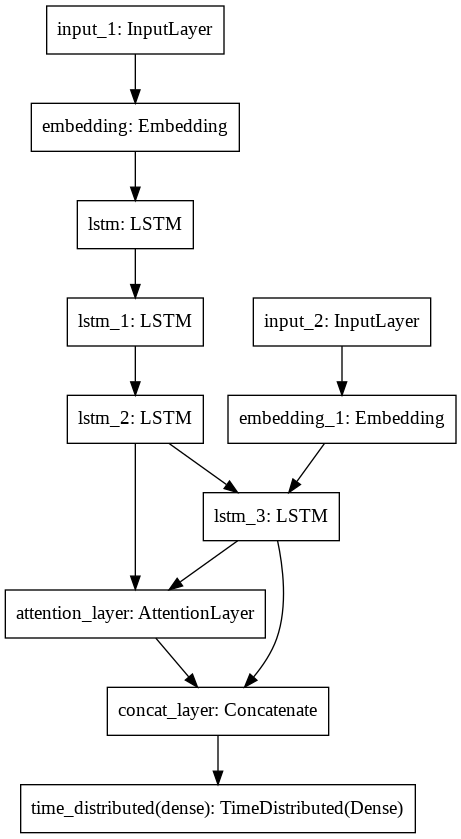

In [ ]:
#Plot the model
tf.keras.utils.plot_model(model) #Complete model
#tf.keras.models.Model(encoder_inputs, encoder_outputs) #Encoder Model

### Callbacks

* CSVLogger - To keep track of train and val loss.
* EarlyStopping - To terminate training in case of overfitting.
* ModelCheckpoint - Save model to avoid retraining if colab crashes

In [ ]:
#Callbacks
#This requires a drive mount
drive_root = '/content/drive/My Drive'
model_name = 'attention_lstm'

#Check if drive is mounted
if not os.path.exists(drive_root):
  print("Please mount google drive for this operation")
  drive.mount('/drive')

#CSVLogger paths
#Check if they exist
csv_dir = os.path.join(drive_root, 'csvLogger')
csv_filename = os.path.join(csv_dir, f'{model_name}.csv')

if not os.path.exists(csv_dir):
  os.makedirs(csv_dir)
  print("CSV directory created at path: ", csv_dir)
else:
  print("CSV directory already exist at path: ", csv_dir)

#ModelCheckpoint paths
#Check if they exist
checkpoint_dir = os.path.join(drive_root, 'checkpoints/project', model_name) #stacked_lstm checkpoints are stored here. Separate for different folders
checkpoint_path = os.path.join(checkpoint_dir, model_name + '_e{epoch}_vl_{val_loss:0.4f}.ckpt')

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
  print("Checkpoints directory created at path: ", checkpoint_dir)
else:
  print("Checkpoints folder already exists at path: ", checkpoint_dir)  

#Create a callback that logs the content in CSV
csv_logger = tf.keras.callbacks.CSVLogger(csv_filename,
                                          separator=',',
                                          append=True)

# Create a callback that stops training for no improvement
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=5)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=False,
                                                 verbose=1)

CSV directory already exist at path:  /content/drive/My Drive/csvLogger
Checkpoints folder already exists at path:  /content/drive/My Drive/checkpoints/project/attention_lstm


###Model Training

1. Load the latest checkpoint if any.
2. Resume or start training.

In [ ]:
#Load the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)

if latest != None:
  print("Loading weights from: ", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from:  /content/drive/My Drive/checkpoints/project/attention_lstm/attention_lstm_e24_vl_2.2893.ckpt


In [ ]:
#Model training
#Uncomment this to train it on toy dataset, overfit and check if everything works fine.

# history = model.fit([x_tr[:32],y_tr[:32,:-1]], y_tr[:32][:,1:,np.newaxis],
#                     epochs=10, batch_size=16,
#                     validation_data = ([x_val[:32],y_val[:32,:-1]], y_val[:32][:,1:,np.newaxis]))

In [ ]:
#Train Model on Complete Dataset
history = model.fit([x_tr[:],y_tr[:,:-1]], y_tr[:][:,1:,np.newaxis],
                    epochs=50, batch_size=512, initial_epoch = 18,
                    validation_data = ([x_val[:],y_val[:,:-1]], y_val[:][:,1:,np.newaxis]),
                    callbacks=[cp_callback, es, csv_logger])

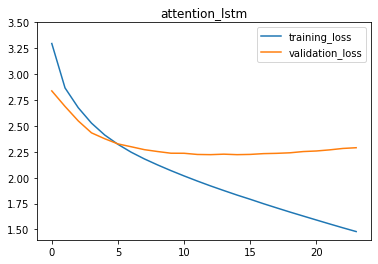

In [ ]:
#Let's check out the model performance
perf_df = pd.read_csv(csv_filename)

plt.ylim(1.4, 3.5)
plt.plot(perf_df['loss'], label='training_loss')
plt.plot(perf_df['val_loss'], label='validation_loss')
plt.legend()
plt.title(f'{model_name}')
plt.show()

##Model Inference

The model for inference is slightly different from the trained model. Here instead of feeding the decoder with input for every timestep, we start by feeding 'xstartx' token. The prediction of the decoder at timestep t act as input for timestep t+1.

In [ ]:
#Model Inference
# encoder inference
encoder_model = tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = tf.keras.layers.Input(shape=(latent_dim,))
decoder_state_input_c = tf.keras.layers.Input(shape=(latent_dim,))
decoder_hidden_state_input = tf.keras.layers.Input(shape=(MAX_TEXT_LEN,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = tf.keras.layers.Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = tf.keras.models.Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
#Define some word_index/index_word dictionaries
reverse_target_word_index = y_tokenizer.index_word.copy()
reverse_source_word_index = x_tokenizer.index_word.copy()
target_word_index = y_tokenizer.word_index.copy()

In [ ]:
#This function decodes a single sequence at a time.
#In the next cell, I've implemented a bath decode function
#Hence this code is obsolete and is for reference only

#Define a function that feeds the output of decoder at time-step t as input to decoder at time-step t recursively
#until 'xendx' token is reached
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['xstartx']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        
        if sampled_token_index == 0:
          decoded_sentence += ' xpadx'
          return decoded_sentence
         
        sampled_token = reverse_target_word_index[sampled_token_index]

        if len(decoded_sentence.split()) >= (MAX_SUM_LEN-2):
          stop_condition = True

        elif (sampled_token!='xendx'):
            decoded_sentence += ' '+sampled_token
            # print("1st if ")

        # Exit condition: either hit max length or find stop word.
        elif (sampled_token == 'xendx'):
            stop_condition = True
            # print(sampled_token)

        # Update the target sequence (of length 1).
        # target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence.strip()

In [ ]:
#Let the padding token '0' represent empty string
reverse_target_word_index[0] = ''

#It's handy to vecotrize mapping from index word operation in numpy.
rtwi = np.vectorize(reverse_target_word_index.get)

#Decode output
def predict_sequences(input_seq):

  # Encode the input as state vectors.
  e_out, e_h, e_c = encoder_model.predict(input_seq)
  # input_seq.shape[0] -> BS
  # "e_out" - (BS, 80, 256), "e_h" - (BS, 256), "e_c" - (BS, 256)
  
  # Generate empty target sequence of length 1.
  target_seq = np.zeros(input_seq.shape[0])

  # Chose the 'start' word as the first words of the target sequences
  target_seq.fill(target_word_index['xstartx'])

  #This will store the string representation of decoded sequence
  decoded_sentence = np.chararray(shape=(input_seq.shape[0],1), unicode=True)

  for i in range(MAX_SUM_LEN):

      output_tokens, h, c = decoder_model.predict([target_seq.reshape(-1,1)] + [e_out, e_h, e_c])
      # "output_tokens" - (BS, 1, 13871), "h" - (BS, 256), "c" - (BS, 256)
      
      # Pick the max probability token for each sequence
      sampled_token_index = np.argmax(output_tokens, axis=-1)
      #shape - (BS,1)

      #Map the index to corresponding word and
      #concatenate it with the decoded_sequence
      decoded_sentence = decoded_sentence + np.char.add(rtwi(sampled_token_index),' ') 

      # Update the target sequence to newly predicted outputs.
      target_seq = sampled_token_index.ravel()

      # Update internal states
      e_h, e_c = h, c

  #Return after remove and stripping whitespace  
  return decoded_sentence.replace('xendx', '').strip()

In [ ]:
##Create a dictionary for inference on validation data
infer_dict = {'val_text': [], 'val_true': [], 'val_pred': [], 'bleu_score': []}

val_true = np.char.array(y_tokenizer.sequences_to_texts(y_val), unicode=True).replace('xstartx','').replace('xendx', '').strip()
infer_dict['val_true'] = val_true.tolist()
infer_dict['val_text'] = x_tokenizer.sequences_to_texts(x_val)
infer_dict['val_pred'] = predict_sequences(x_val).ravel().tolist()

In [ ]:
#Calculate bleu score
infer_dict['bleu_score'] = [sentence_bleu([r.split()], h.split(), weights=[1,0,0,0]) 
                            for r,h in zip(infer_dict['val_true'], infer_dict['val_pred'])]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
#Make a dataframe from inference dictionary and export it
infer_df = pd.DataFrame(infer_dict)
infer_df.to_csv(os.path.join(csv_dir, f'{model_name}_infer.csv'))

infer_df.head()

,val_text,val_true,val_pred,bleu_score
0,recently student class brought liquorice share...,mmmmm good,good flavor,0.500000
1,coffee drinkers tastes wide varied like coffee...,not great not terrible,good coffee,0.000000
2,one best tasting granola good ceral well regul...,great tasting but bit pricey,great granola,0.111565
3,say wow tangy sweet fruity refreshing hard ima...,the gum chewing has been waiting for,delicious,0.000000
4,used eating flaxseed brownie hodgson mill brow...,delicious brownie,best brownie ever,0.333333


In [ ]:
#Print some random results
print("Let's print some random results from inference dataframe -")
for i, row in infer_df.sample(5).iterrows():
  
  print("\nText: ", row['val_text'])
  print("Original Summary: ", row['val_true'])
  print("Predicted Summary: ", row['val_pred'])
  print("BLEU unigram score: ", row['bleu_score'])

print("\nAverage BLEU score: ", infer_df.bleu_score.mean())

Let's print some random results from inference dataframe -

Text:  use get virginia peanuts family first year bought online company virginia gourment peanuts exactly expected purchasing
Original Summary:  great peanuts great value
Predicted Summary:  peanut butter review
BLEU unigram score:  0.0

Text:  cookies arrived fresh delicious usual good value plenty share understand use word necessary describe experience
Original Summary:  famous amos
Predicted Summary:  great cookies
BLEU unigram score:  0.0

Text:  really loved pasta tastes like natural spaghetti without pain issues associated gluten many products would come mushy like oatmeal one tastes much like ordinary pasta cannot tell difference purchased bionaturae organic gluten free pasta heartland pasta increased price frequently stock longer subscribe save option product mentioned bionaturae pasta gives packs spaghetti still costs less choosing subscribe save bionaturae offered subscribe save also great reviews see turns measure h